In [1]:
!pip install pandas

In [14]:
# Cell 0: imports & config
import os, math, json, random
import numpy as np
import torch
import psutil
import pandas as pd

from pathlib import Path
from typing import Tuple, Dict, List

import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

plt.rcParams["figure.dpi"] = 120

DATA_DIR =  Path("/Users/julianquast/Downloads/pusht_noise-2")
ACTIONS_PATH = DATA_DIR / "train/rel_actions.pth"
EPISODES_LENGTHS_PATH = DATA_DIR / "train/seq_lengths.pkl"

# sweeps
R_SWEEP = [15, 18, 20, 21, 23, 24,25,26,27,30]      # px
KMEANS_KS = [5,8,9,10,14,15,16]                             # add 32 if desired
N_SAMPLES = 50_000
SEEDS = [0, 1, 2, 3, 4, 5,6,7,8,9]                               # replicate to estimate variability

OUT_DIR = Path("./action_discretization_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)


Loaded actions: (4596510, 2), total=4,596,510
Magnitude stats (px): mean=12.33, median=2.52, p95=47.55, p99=67.05, max=204.27


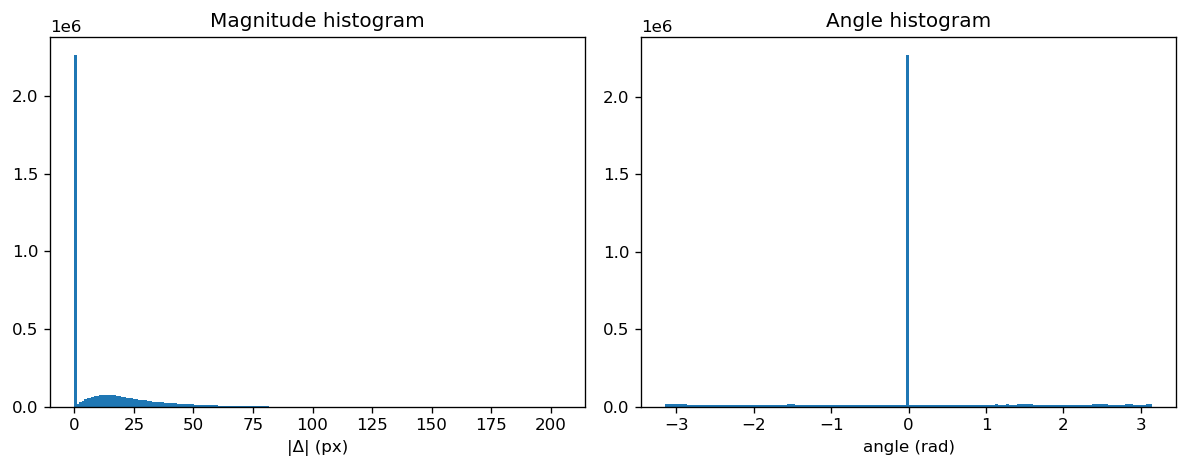

In [15]:
# Cell 1: load & flatten (no clamping)
rel_actions = torch.load(ACTIONS_PATH, map_location="cpu")  # shape possibly [episodes, T, 2] or [N,2]
flat = rel_actions.view(-1, 2).numpy().astype(np.float32, copy=False)
N_total = len(flat)
print(f"Loaded actions: {flat.shape}, total={N_total:,}")

# magnitudes and angles for inspection
mag = np.linalg.norm(flat, axis=1)
ang = np.arctan2(flat[:,1], flat[:,0])

print("Magnitude stats (px):",
      f"mean={mag.mean():.2f}, median={np.median(mag):.2f}, p95={np.percentile(mag,95):.2f}, p99={np.percentile(mag,99):.2f}, max={mag.max():.2f}")

# quick histograms (optional)
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(mag, bins=200)
axes[0].set_title("Magnitude histogram")
axes[0].set_xlabel("|Δ| (px)")

axes[1].hist(ang, bins=180)
axes[1].set_title("Angle histogram")
axes[1].set_xlabel("angle (rad)")
plt.tight_layout()
plt.show()


In [17]:
# === Cell: Filter episodes using EPISODES_LENGTHS_PATH (handles (E,T,2) arrays) ===
import os, pickle, numpy as np, pandas as pd

# ---- Config: choose ONE of the two threshold modes below ----
USE_PERCENTILE = True     # set False to use absolute threshold in pixels
PERCENTILE     = 99.0     # e.g., 99 means "drop episodes with any action above p99 magnitude"
ABS_THRESHOLD  = 60.0     # used only if USE_PERCENTILE == False

# ---- Load episode lengths from EPISODES_LENGTHS_PATH ----
assert 'EPISODES_LENGTHS_PATH' in globals(), "EPISODES_LENGTHS_PATH is not defined"
assert os.path.exists(EPISODES_LENGTHS_PATH), f"EPISODES_LENGTHS_PATH not found: {EPISODES_LENGTHS_PATH}"
with open(EPISODES_LENGTHS_PATH, "rb") as f:
    ep_lengths = np.asarray(pickle.load(f), dtype=np.int64)

# ---- Ensure rel_actions is numpy and has shape (E,T,2) or (N,2) ----
if hasattr(rel_actions, "detach"):  # torch tensor
    ra_np = rel_actions.detach().cpu().numpy()
else:
    ra_np = np.asarray(rel_actions)

assert ra_np.ndim in (2, 3), "rel_actions must be (N,2) or (E,T,2)"

# ---- Build per-episode starts/ends and flatten valid steps only ----
if ra_np.ndim == 3:
    E, T_max, D = ra_np.shape
    assert D == 2, "last dim of rel_actions must be 2"
    assert ep_lengths.size == E, f"len(ep_lengths)={ep_lengths.size} must match rel_actions.shape[0]={E}"
    starts = np.r_[0, np.cumsum(ep_lengths)[:-1]]
    ends   = starts + ep_lengths
    # Concatenate only valid steps per episode (no padding)
    flat_list = [ra_np[i, :ep_lengths[i], :] for i in range(E) if ep_lengths[i] > 0]
    actions = np.concatenate(flat_list, axis=0) if flat_list else np.empty((0,2), dtype=ra_np.dtype)
else:
    # Already flat (N,2); ep_lengths must sum to N
    actions = ra_np
    E = ep_lengths.size
    assert actions.shape[1] == 2, "rel_actions last dim must be 2"
    assert ep_lengths.sum() == actions.shape[0], \
        f"Sum of ep lengths ({ep_lengths.sum():,}) must equal N actions ({actions.shape[0]:,})"
    starts = np.r_[0, np.cumsum(ep_lengths)[:-1]]
    ends   = starts + ep_lengths

N = actions.shape[0]
assert N == ep_lengths.sum(), f"Flattened actions N ({N:,}) must equal sum(ep_lengths) ({ep_lengths.sum():,})"

# ---- Magnitudes & threshold ----
mag = np.linalg.norm(actions, axis=1)
if USE_PERCENTILE:
    threshold = float(np.percentile(mag, PERCENTILE))
    th_desc = f">{PERCENTILE:.2f}p ({threshold:.2f}px)"
else:
    threshold = float(ABS_THRESHOLD)
    th_desc = f">{threshold:.2f}px"

# ---- Per-episode max magnitude (drop episodes with any outlier) ----
ep_max = np.empty(E, dtype=np.float32)
for i, (s, e) in enumerate(zip(starts, ends)):
    ep_max[i] = mag[s:e].max() if e > s else 0.0

keep_episode_mask = ep_max <= threshold
kept_E = int(keep_episode_mask.sum())

# ---- Build action mask for kept episodes ----
keep_action_mask = np.zeros(N, dtype=bool)
for s, e, keep in zip(starts, ends, keep_episode_mask):
    if keep and e > s:
        keep_action_mask[s:e] = True
kept_N = int(keep_action_mask.sum())

# ---- Outlier action stats (overall) ----
outlier_action_mask = mag > threshold
outlier_N = int(outlier_action_mask.sum())

# ---- Report summary ----
summary = {
    "rel_actions shape": str(ra_np.shape),
    "Flattened (N,2)": f"{N:,}",
    "Threshold": th_desc,
    "Episodes (total)": f"{E:,}",
    "Episodes kept": f"{kept_E:,} ({kept_E/E*100:.2f}%)",
    "Actions (total)": f"{N:,}",
    "Actions kept": f"{kept_N:,} ({kept_N/N*100:.2f}%)",
    "Outlier actions": f"{outlier_N:,} ({outlier_N/N*100:.2f}%)",
    "Kept |Δ| mean (px)": np.nan,
    "Kept |Δ| median (px)": np.nan,
    "Kept |Δ| p95 (px)": np.nan,
    "Kept |Δ| p99 (px)": np.nan,
    "Kept |Δ| max (px)": np.nan,
}
if kept_N > 0:
    kept_mag = mag[keep_action_mask]
    summary.update({
        "Kept |Δ| mean (px)": round(float(kept_mag.mean()), 2),
        "Kept |Δ| median (px)": round(float(np.median(kept_mag)), 2),
        "Kept |Δ| p95 (px)": round(float(np.percentile(kept_mag, 95)), 2),
        "Kept |Δ| p99 (px)": round(float(np.percentile(kept_mag, 99)), 2),
        "Kept |Δ| max (px)": round(float(kept_mag.max()), 2),
    })

display(pd.DataFrame([summary]))

# ---- Expose handy variables for downstream cells ----
FILTER_INFO = {
    "threshold_px": threshold,
    "threshold_desc": th_desc,
    "episode_starts": starts,
    "episode_ends": ends,
    "keep_episode_mask": keep_episode_mask,   # shape (E,)
    "keep_action_mask": keep_action_mask,     # shape (N,)
    "kept_actions_idx": np.flatnonzero(keep_action_mask),
    "ep_max_per_episode": ep_max,
    "outlier_action_mask": outlier_action_mask,
    "flattened_actions": actions,             # (N,2) valid-only, no padding
}

print(f"[Saved] FILTER_INFO with masks and indices. Use FILTER_INFO['kept_actions_idx'] to subset arrays.")


,rel_actions shape,"Flattened (N,2)",Threshold,Episodes (total),Episodes kept,Actions (total),Actions kept,Outlier actions,Kept |Δ| mean (px),Kept |Δ| median (px),Kept |Δ| p95 (px),Kept |Δ| p99 (px),Kept |Δ| max (px)
0,"(18685, 246, 2)","2,336,736",>99.00p (75.52px),"18,685","10,956 (58.64%)","2,336,736","1,294,457 (55.40%)","23,368 (1.00%)",22.29,18.99,51.43,63.24,75.51


[Saved] FILTER_INFO with masks and indices. Use FILTER_INFO['kept_actions_idx'] to subset arrays.


In [5]:
# Cell 2: sampling helpers
def sample_uniform(xy: np.ndarray, n: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(xy), size=min(n, len(xy)), replace=False)
    return xy[idx]

def sample_stratified_by_magnitude(xy: np.ndarray, n: int, seed: int, n_bins: int = 20) -> np.ndarray:
    # equal-frequency bins by magnitude; sample equally from bins
    rng = np.random.default_rng(seed)
    mag = np.linalg.norm(xy, axis=1)
    # edges from quantiles
    qs = np.linspace(0, 1, n_bins+1)
    edges = np.quantile(mag, qs)
    # deduplicate edges (in case of ties)
    edges = np.unique(edges)
    # assign bins
    bin_idx = np.minimum(np.searchsorted(edges, mag, side="right") - 1, len(edges)-2)
    # compute per-bin sample counts
    bins = [np.where(bin_idx == b)[0] for b in range(len(edges)-1)]
    per_bin = n // max(1, (len(edges)-1))
    sel = []
    for inds in bins:
        if len(inds) == 0: 
            continue
        k = min(per_bin, len(inds))
        sel.extend(rng.choice(inds, size=k, replace=False))
    # top-up if rounding left us short
    if len(sel) < n:
        remaining = np.setdiff1d(np.arange(len(xy)), np.array(sel, dtype=int), assume_unique=False)
        k = n - len(sel)
        if k > 0 and len(remaining) > 0:
            sel.extend(rng.choice(remaining, size=min(k, len(remaining)), replace=False))
    return xy[np.array(sel, dtype=int)]


In [6]:
# Cell 3: discretizers
def compass_dirs_8():
    # standard 8 directions: 0°,45°,...,315° from +x axis
    return np.linspace(0, 2*np.pi, 8, endpoint=False)

def build_fixed_compass_9(r: float) -> np.ndarray:
    dirs = compass_dirs_8()
    vecs = np.stack([r*np.cos(dirs), r*np.sin(dirs)], axis=1)
    return np.vstack([np.zeros(2), vecs]).astype(np.float32)  # center + 8

def build_fixed_compass_5(r: float) -> np.ndarray:
    dirs = np.array([0, np.pi/2, np.pi, 3*np.pi/2])  # E, N, W, S
    vecs = np.stack([r*np.cos(dirs), r*np.sin(dirs)], axis=1)
    return np.vstack([np.zeros(2), vecs]).astype(np.float32)  # center + 4

def build_hybrid_compass_9(xy: np.ndarray) -> np.ndarray:
    # assign to 8 equal sectors and compute mean magnitude per sector
    ang = np.arctan2(xy[:,1], xy[:,0])
    mag = np.linalg.norm(xy, axis=1)
    # sector edges centered on standard compass rays
    edges = np.linspace(-np.pi, np.pi, 9)
    sec_idx = np.digitize(ang, edges) - 1
    sec_idx = np.clip(sec_idx, 0, 7)
    mean_r = np.array([mag[sec_idx == i].mean() if np.any(sec_idx == i) else 0.0 for i in range(8)])
    dirs = compass_dirs_8()
    vecs = np.stack([mean_r*np.cos(dirs), mean_r*np.sin(dirs)], axis=1)
    return np.vstack([np.zeros(2), vecs]).astype(np.float32)

# --- Hybrid 5: center + 4 cardinal directions with data-adaptive radii ---

def compass_dirs_4():
    # cardinals: 0° (E), 90° (N), 180° (W), 270° (S) from +x axis
    return np.array([0.0, np.pi/2, np.pi, 3*np.pi/2], dtype=np.float64)

def compass_dirs_4():
    return np.array([0.0, np.pi/2, np.pi, 3*np.pi/2], dtype=np.float64)

def build_hybrid_compass_5(xy: np.ndarray) -> np.ndarray:
    """Center + 4 cardinals (E,N,W,S) with per-direction MEAN radius from data."""
    if xy.ndim != 2 or xy.shape[1] != 2:
        raise ValueError("xy must be (N,2) array of Δx,Δy")
    ang = np.arctan2(xy[:, 1], xy[:, 0])
    mag = np.linalg.norm(xy, axis=1)
    dirs = compass_dirs_4()

    # nearest-direction assignment (wrap-safe)
    diffs = np.arctan2(np.sin(ang[:, None] - dirs[None, :]),
                       np.cos(ang[:, None] - dirs[None, :]))
    sec_idx = np.abs(diffs).argmin(axis=1)

    mean_r = np.array([float(mag[sec_idx == i].mean()) if np.any(sec_idx == i) else 0.0
                       for i in range(4)], dtype=np.float32)

    vecs = np.stack([mean_r * np.cos(dirs), mean_r * np.sin(dirs)], axis=1)
    return np.vstack([np.zeros(2, dtype=np.float32), vecs]).astype(np.float32)



def kmeans_centers(xy: np.ndarray, K: int, seed: int) -> np.ndarray:
    km = MiniBatchKMeans(n_clusters=K, random_state=seed, batch_size=1024, n_init="auto")
    km.fit(xy)
    return km.cluster_centers_.astype(np.float32)


In [7]:
# Cell 4: evaluation helpers
def quantize_error(xy: np.ndarray, centers: np.ndarray) -> Dict[str, float]:
    # distances to centers
    diffs = xy[:, None, :] - centers[None, :, :]
    dists = np.linalg.norm(diffs, axis=2)
    labels = np.argmin(dists, axis=1)
    errs = dists[np.arange(len(xy)), labels]

    def entropy(labels):
        counts = np.bincount(labels, minlength=len(centers))
        p = counts / counts.sum()
        p = p[p > 0]
        return float(-(p*np.log2(p)).sum())

    e_mean = float(errs.mean())
    e_p95  = float(np.percentile(errs, 95))
    e_p99  = float(np.percentile(errs, 99))
    e_mean_trim = float(pd.Series(errs).clip(upper=np.percentile(errs, 99.5)).mean())
    e_p95_trim  = float(np.percentile(np.clip(errs, None, np.percentile(errs, 99.5)), 95))
    ent = entropy(labels)

    return dict(mean=e_mean, p95=e_p95, p99=e_p99,
                mean_trim=e_mean_trim, p95_trim=e_p95_trim,
                entropy=ent, n_centers=len(centers))


In [8]:
# Cell 5: run sweeps and collect results
records = []

for sampler_name in ["uniform50k", "strat50k"]:
    for seed in SEEDS:
        if sampler_name == "uniform50k":
            xy = sample_uniform(flat, N_SAMPLES, seed)
        else:
            xy = sample_stratified_by_magnitude(flat, N_SAMPLES, seed)

        # Fixed compass 9
        for r in R_SWEEP:
            centers = build_fixed_compass_9(r)
            metrics = quantize_error(xy, centers)
            records.append({
                "sampler": sampler_name, "seed": seed,
                "method": "fixed_compass_9", "param": r, **metrics
            })

        # Fixed compass 5
        for r in R_SWEEP:
            centers = build_fixed_compass_5(r)
            metrics = quantize_error(xy, centers)
            records.append({
                "sampler": sampler_name, "seed": seed,
                "method": "fixed_compass_5", "param": r, **metrics
            })

        # Hybrid compass 9 (uses the same sample to estimate radii)
        centers = build_hybrid_compass_9(xy)
        metrics = quantize_error(xy, centers)
        records.append({
            "sampler": sampler_name, "seed": seed,
            "method": "hybrid_compass_9", "param": "auto", **metrics
        })

        # Hybrid compass 5 (mean radii from data; same-sample fit as hybrid-9)
        centers = build_hybrid_compass_5(xy)
        metrics = quantize_error(xy, centers)
        records.append({
            "sampler": sampler_name, "seed": seed,
            "method": "hybrid_compass_5", "param": "auto", **metrics
        })



        # KMeans with K ∈ {9,16}
        for K in KMEANS_KS:
            centers = kmeans_centers(xy, K, seed)
            metrics = quantize_error(xy, centers)
            records.append({
                "sampler": sampler_name, "seed": seed,
                "method": f"kmeans_{K}", "param": K, **metrics
            })

df = pd.DataFrame.from_records(records)
df.to_csv(OUT_DIR / "quantization_results_raw.csv", index=False)
df.head()


/Users/julianquast/miniforge3/envs/dino_wm/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,sampler,seed,method,param,mean,p95,p99,mean_trim,p95_trim,entropy,n_centers
0,uniform50k,0,fixed_compass_9,15,6.795548,32.722478,51.865740,6.730536,32.722478,2.324613,9
1,uniform50k,0,fixed_compass_9,18,6.362988,29.940787,49.074941,6.297993,29.940787,2.249676,9
2,uniform50k,0,fixed_compass_9,20,6.177101,28.070391,47.102496,6.112405,28.070391,2.194933,9
3,uniform50k,0,fixed_compass_9,21,6.111125,27.147884,46.174737,6.046586,27.147884,2.166089,9
4,uniform50k,0,fixed_compass_9,23,6.025127,25.321719,44.306566,5.960594,25.321719,2.103643,9


In [9]:
# Cell 6: aggregate across seeds
agg = (df
       .groupby(["sampler","method","param"], dropna=False)
       .agg(mean_mean=("mean","mean"),
            std_mean=("mean","std"),
            mean_p95=("p95","mean"),
            std_p95=("p95","std"),
            mean_entropy=("entropy","mean"),
            std_entropy=("entropy","std"),
            mean_p99=("p99","mean"),
            std_p99=("p99","std"),
            mean_mean_trim=("mean_trim","mean"),
            mean_p95_trim=("p95_trim","mean"))
       .reset_index()
       .sort_values(["sampler","method","param"]))

agg.to_csv(OUT_DIR / "quantization_results_agg.csv", index=False)
agg.head(100)


,sampler,method,param,mean_mean,std_mean,mean_p95,std_p95,mean_entropy,std_entropy,mean_p99,std_p99,mean_mean_trim,mean_p95_trim
0,strat50k,fixed_compass_5,15,14.127580,0.017503,42.283955,0.160684,2.318541,0.000367,61.108429,0.371682,14.053949,42.283955
1,strat50k,fixed_compass_5,18,13.555153,0.019610,39.812787,0.164132,2.305460,0.000558,58.568150,0.396876,13.481381,39.812787
2,strat50k,fixed_compass_5,20,13.320648,0.020758,38.227479,0.168154,2.287024,0.000677,56.904828,0.327787,13.247102,38.227479
3,strat50k,fixed_compass_5,21,13.241473,0.021108,37.441936,0.166402,2.274675,0.001142,56.042103,0.310765,13.167988,37.441936
4,strat50k,fixed_compass_5,23,13.149426,0.021581,35.883431,0.138760,2.243928,0.001012,54.447350,0.306409,13.075973,35.883431
5,strat50k,fixed_compass_5,24,13.133088,0.021943,35.154013,0.129290,2.225950,0.001100,53.635738,0.312402,13.059687,35.154013
6,strat50k,fixed_compass_5,25,13.134395,0.022203,34.424910,0.135782,2.206264,0.000999,52.816396,0.293392,13.061089,34.424910
7,strat50k,fixed_compass_5,26,13.152034,0.022461,33.734508,0.137272,2.185763,0.000984,52.051723,0.300709,13.078693,33.734508
8,strat50k,fixed_compass_5,27,13.185112,0.022743,33.063489,0.142195,2.164600,0.001250,51.276084,0.306069,13.111761,33.063489
9,strat50k,fixed_compass_5,30,13.364242,0.023482,31.185970,0.138510,2.092535,0.001453,48.992172,0.308550,13.291275,31.185970


In [73]:
# # Cell 7: visualization
# def plot_r_sweep(agg, sampler):
#     sub = agg[(agg["sampler"]==sampler) & (agg["method"].isin(["fixed_compass_9","fixed_compass_5"]))]
#     plt.figure(figsize=(6,4))
#     for meth in ["fixed_compass_9","fixed_compass_5"]:
#         ss = sub[sub["method"]==meth].copy()
#         ss = ss.sort_values("param")
#         plt.plot(ss["param"], ss["mean_mean"], "o-", label=f"{meth} mean")
#         plt.plot(ss["param"], ss["mean_p95"], "s--", label=f"{meth} p95")
#     plt.xlabel("r (px)"); plt.ylabel("error (px)")
#     plt.title(f"{sampler}: fixed compass sweeps")
#     plt.legend(); plt.grid(True); plt.tight_layout()
#     plt.show()

# for smp in ["uniform50k","strat50k"]:
#     plot_r_sweep(agg, smp)

# # bar plot comparing methods (best r for fixed)
# best_fixed = (agg
#               [(agg["method"].isin(["fixed_compass_9","fixed_compass_5"])) & (agg["sampler"]=="uniform50k")]
#               .sort_values(["method","mean_mean"])
#               .groupby("method").head(1))

# compare = pd.concat([
#     best_fixed,
#     agg[(agg["sampler"]=="uniform50k") & (agg["method"].isin(["hybrid_compass_9","kmeans_9","kmeans_16"]))]
# ])

# plt.figure(figsize=(7,4))
# x = np.arange(len(compare))
# plt.bar(x-0.2, compare["mean_mean"], width=0.4, label="mean")
# plt.bar(x+0.2, compare["mean_p95"], width=0.4, label="p95")
# plt.xticks(x, compare["method"], rotation=15)
# plt.ylabel("error (px)")
# plt.title("Uniform50k: method comparison (best fixed-r)")
# plt.legend(); plt.tight_layout(); plt.show()


In [18]:
# Cell 8: decision table (uniform50k; include best-r rows)

def best_fixed_row(method):
    sub = agg[(agg["sampler"] == "uniform50k") & (agg["method"] == method)]
    return sub.sort_values("mean_mean").iloc[0]

# Helper: interpretability labels
def interpretability_label(method: str) -> str:
    if method.startswith("fixed_compass"):
        return "Very High"
    if method.startswith("hybrid_compass"):
        return "High"
    if method.startswith("kmeans_"):
        try:
            k = int(method.split("_")[1])
        except Exception:
            return "Unknown"
        if k <= 5:
            return "Medium–High"
        elif k <= 10:
            return "Medium"
        elif k <= 16:
            return "Low"
        else:
            return "Very Low"
    return "Unknown"

rows = []

# Best r for fixed families
for m in ["fixed_compass_9", "fixed_compass_5"]:
    if not agg[(agg["sampler"]=="uniform50k") & (agg["method"]==m)].empty:
        rows.append(best_fixed_row(m))

# Hybrid (single "auto" row per sampler/method; pick its row if present)
for m in ["hybrid_compass_9", "hybrid_compass_5"]:
    sub = agg[(agg["sampler"]=="uniform50k") & (agg["method"]==m)]
    if not sub.empty:
        rows.append(sub.iloc[0])

# KMeans: display only the requested K
kmeans_keep = [16, 15, 10,9, 8, 5]
for K in kmeans_keep:
    sub = agg[(agg["sampler"]=="uniform50k") & (agg["method"]==f"kmeans_{K}")]
    if not sub.empty:
        rows.append(sub.iloc[0])

# Build and save table
dec = pd.DataFrame([{
    "Method": r.method,
    "Param": r.param,
    "Mean Error (px)": round(r.mean_mean, 2),
    "95th (px)": round(r.mean_p95, 2),
    "Entropy (bits)": round(r.mean_entropy, 2),
    "Mean Error (trimmed, px)": round(r.mean_mean_trim, 2),
    "95th (trimmed, px)": round(r.mean_p95_trim, 2),
    "Interpretability": interpretability_label(r.method),
} for r in rows])

dec.to_csv(OUT_DIR / "decision_table_uniform50k.csv", index=False)
dec




,Method,Param,Mean Error (px),95th (px),Entropy (bits),"Mean Error (trimmed, px)","95th (trimmed, px)",Interpretability
0,fixed_compass_9,26,6.07,23.06,2.02,6.00,23.06,Very High
1,fixed_compass_5,24,7.25,27.89,1.65,7.19,27.89,Very High
2,hybrid_compass_9,auto,6.32,25.75,2.27,6.25,25.75,High
3,hybrid_compass_5,auto,7.78,31.64,1.81,7.70,31.64,High
4,kmeans_16,16,4.73,15.58,2.68,4.66,15.58,Low
5,kmeans_15,15,4.82,15.95,2.58,4.76,15.95,Low
6,kmeans_10,10,5.85,18.52,2.13,5.79,18.52,Medium
7,kmeans_9,9,6.24,19.22,1.99,6.17,19.22,Medium
8,kmeans_8,8,6.60,20.10,1.86,6.53,20.10,Medium
9,kmeans_5,5,7.70,24.57,1.44,7.63,24.57,Medium–High


In [19]:
# Cell 9: LaTeX export
latex = dec.to_latex(index=False, caption="Quantization quality across discretization methods (uniform 50k sample).",
                     label="tab:quantization_methods", float_format="%.2f")
with open(OUT_DIR / "decision_table_uniform50k.tex", "w") as f:
    f.write(latex)

print(latex)


\begin{table}
\caption{Quantization quality across discretization methods (uniform 50k sample).}
\label{tab:quantization_methods}
\begin{tabular}{llrrrrrl}
\toprule
Method & Param & Mean Error (px) & 95th (px) & Entropy (bits) & Mean Error (trimmed, px) & 95th (trimmed, px) & Interpretability \\
\midrule
fixed_compass_9 & 26 & 6.07 & 23.06 & 2.02 & 6.00 & 23.06 & Very High \\
fixed_compass_5 & 24 & 7.25 & 27.89 & 1.65 & 7.19 & 27.89 & Very High \\
hybrid_compass_9 & auto & 6.32 & 25.75 & 2.27 & 6.25 & 25.75 & High \\
hybrid_compass_5 & auto & 7.78 & 31.64 & 1.81 & 7.70 & 31.64 & High \\
kmeans_16 & 16 & 4.73 & 15.58 & 2.68 & 4.66 & 15.58 & Low \\
kmeans_15 & 15 & 4.82 & 15.95 & 2.58 & 4.76 & 15.95 & Low \\
kmeans_10 & 10 & 5.85 & 18.52 & 2.13 & 5.79 & 18.52 & Medium \\
kmeans_9 & 9 & 6.24 & 19.22 & 1.99 & 6.17 & 19.22 & Medium \\
kmeans_8 & 8 & 6.60 & 20.10 & 1.86 & 6.53 & 20.10 & Medium \\
kmeans_5 & 5 & 7.70 & 24.57 & 1.44 & 7.63 & 24.57 & Medium–High \\
\bottomrule
\end{tabular}
\en

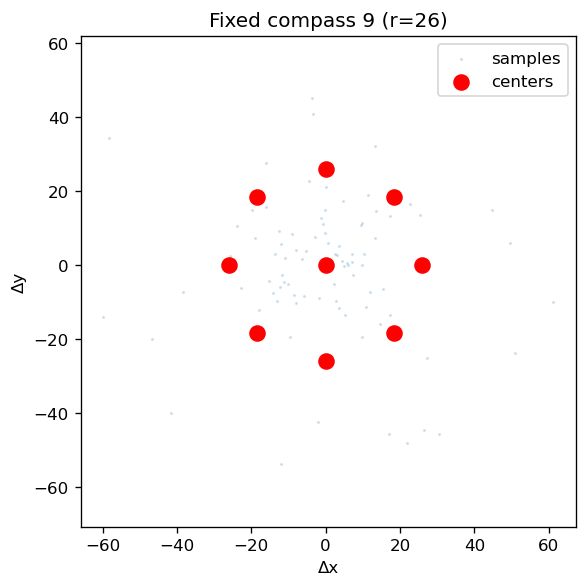

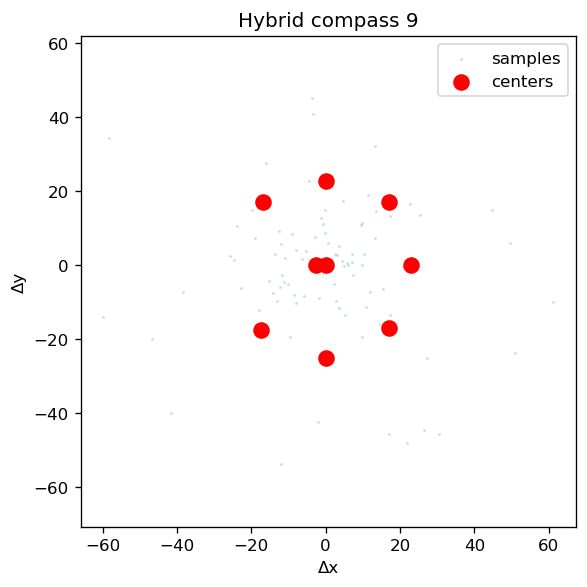

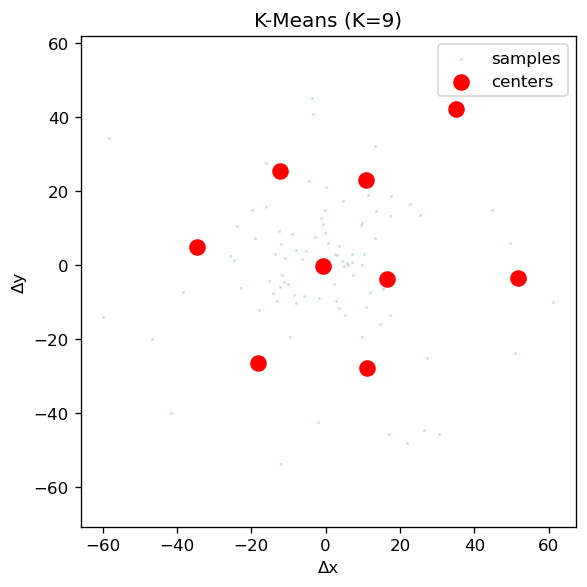

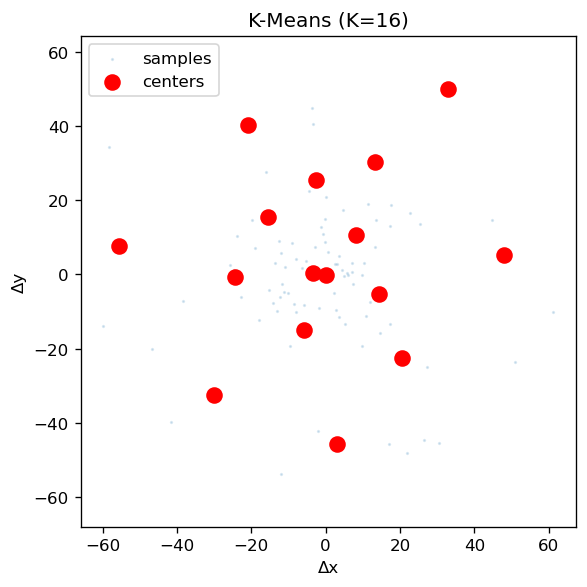

In [77]:
# Cell 10: visualize centers for chosen methods
def scatter_with_centers(xy, centers, title):
    plt.figure(figsize=(5,5))
    plt.scatter(xy[::300,0], xy[::300,1], s=1, alpha=0.15, label="samples")
    plt.scatter(centers[:,0], centers[:,1], s=80, c="red", label="centers")
    plt.axis("equal"); plt.legend(); plt.title(title); plt.xlabel("Δx"); plt.ylabel("Δy")
    plt.tight_layout(); plt.show()

seed = 0
xy = sample_uniform(flat, 50_000, seed)

# best fixed r for 9 compass
best9 = (agg[(agg["sampler"]=="uniform50k") & (agg["method"]=="fixed_compass_9")]
         .sort_values("mean_mean").iloc[0]["param"])
scatter_with_centers(xy, build_fixed_compass_9(best9), f"Fixed compass 9 (r={best9})")

scatter_with_centers(xy, build_hybrid_compass_9(xy), "Hybrid compass 9")

for K in [9,16]:
    scatter_with_centers(xy, kmeans_centers(xy, K, seed), f"K-Means (K={K})")
